<a href="https://colab.research.google.com/github/LamineGith/PyTorch/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder with both traditional NN and CNN

An autoencoder neural network is an unsupervised machine learning algorithm. In an autoencoder, the number of hidden cells is smaller than the input cells. The number of input cells in autoencoders equals to the number of output cells. On an AE network, we train it to display the output, which is as close as the fed input, which forces AEs to find common patterns and generalize the data. We use autoencoders for the smaller representation of the input. This property is useful in many applications, in particular in compressing data or comparing images on a metric beyond pixel-level comparisons.



## Autoencoder with traiditional NN

### Dataset

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# Define the transform to preprocess the data
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset
mnist_data = datasets.MNIST(root='.', train=True, download=True, transform=transform)

# Define the data loader
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=64, shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



### Model Build
It is composed of two main parts: an encoder and a decoder. The encoder maps the input data to a lower-dimensional representation (also known as the bottleneck or latent representation), and the decoder maps the bottleneck representation back to the original input space (reconstruction). The goal of the autoencoder is to learn a compact representation of the input data that can be used for tasks such as dimensionality reduction, denoising, and generative modeling.

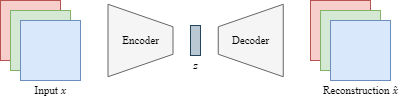

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        '''A class that implements an AutoEncoder with NN linear
           Implementation of the Encoder and the decoder. Input size is 784 while using the MNISt dataset.
         Remember the input of the encoder is the same as the last output of decoder
        '''
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32))
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        """
        The forward function takes in an image (x) and returns the reconstructed image. 
        The latent is also returned in this case while it can be used for the visualization of latent representation
        """
        latent = self.encoder(x)
        x = self.decoder(latent)
        return x,latent

# Define the model and move it to the device
model = Autoencoder()
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.parameters

<bound method Module.parameters of Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
  )
)>

In [13]:
help(model)

### Train Model 

In [14]:

# Train the model
for epoch in range(10):
    for data in data_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = img.to(device)

        output, latent = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch [{}/{}], Loss: {:.4f}".format(epoch+1, 10, loss.item()))

Epoch [1/10], Loss: 0.0266
Epoch [2/10], Loss: 0.0235
Epoch [3/10], Loss: 0.0175
Epoch [4/10], Loss: 0.0131
Epoch [5/10], Loss: 0.0116
Epoch [6/10], Loss: 0.0108
Epoch [7/10], Loss: 0.0123
Epoch [8/10], Loss: 0.0120
Epoch [9/10], Loss: 0.0094
Epoch [10/10], Loss: 0.0092


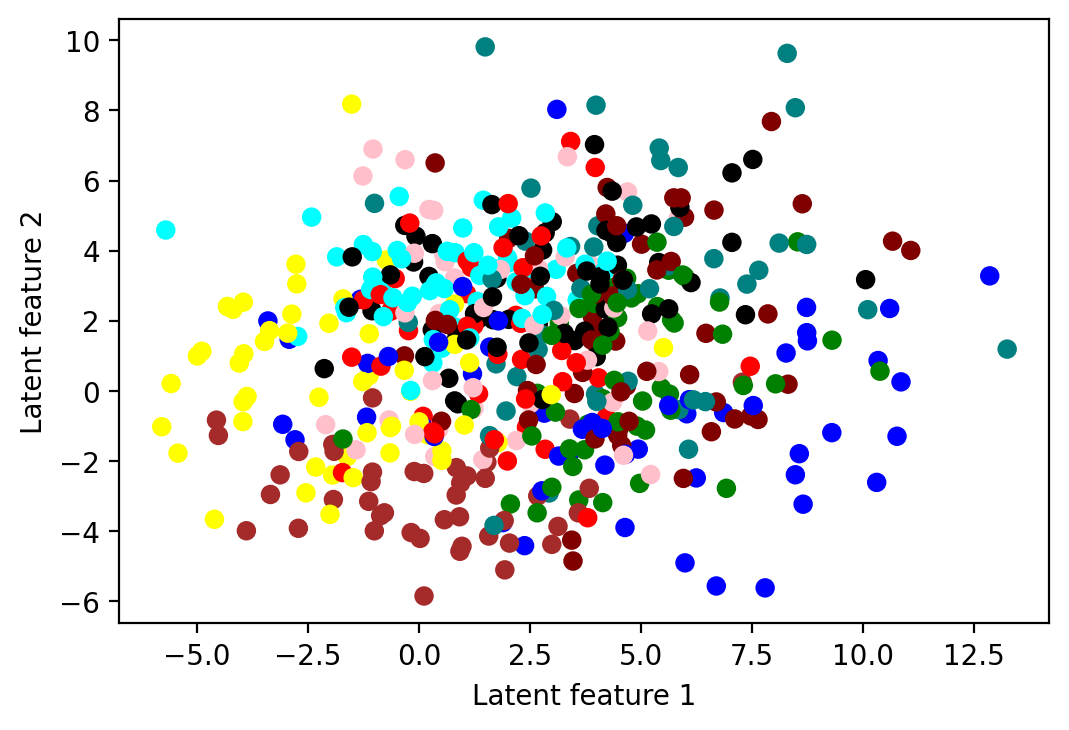

In [15]:
# Visualize the original and reconstructed images
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

dataloader = DataLoader(mnist_data, batch_size=512, shuffle=True)
for data in dataloader:
        img, labels = data
        img = img.view(img.size(0), -1)    
        model.cpu()    
        _,latent = model(img)
        break

d = {0: 'red', 1: "green", 2: "blue", 3: "maroon", 4: "yellow", 
     5: "pink", 6: "brown", 7: "black", 8: "teal", 9: "aqua"}

colors = []       
for e in labels.numpy():
    colors.append(d[e])

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.set_xlabel('Latent feature 1')
ax.set_ylabel('Latent feature 2')

ax.scatter(latent[:,0].detach().numpy(), latent[:,1].detach().numpy(), 
           c=list(colors))

## Autoencoder with CNN

In this part, we will inplement AE using the “deconvolution” (or transposed convolution) with Conv2D and ConvTranspose2d. Conv2D is mainly used when you want to detect features, e.g., in the encoder part of an autoencoder model, and it may shrink your input shape (that's the main idea of the encode to reduce dimension).
Conversely, Conv2DTranspose is used for creating features, for example, in the decoder part of an autoencoder model for constructing an image (for the reconstruction). It makes the input shape larger.

### Dataset

In [18]:
# Load the data
transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


### Model Build

In [27]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

class Autoencoder(nn.Module):
    def __init__(self):
        """
        A Conv2d module applies a 2D convolution over an input signal composed of several input planes.
        We define:
        kernel_size: Size of the convolving kernel
        stride : controls the stride for the cross-correlation, a single number or a tuple.
        padding : controls the amount of padding applied to the input.
        in_channels : 3. In CIFAR10, each image has 3 color channels and is 32x32 pixels large. 
        So we can use 3 channels instead of using the black-and-white
        out_channels : 6
        As always the input of the decoder is the output of the encoder and the decoder reconstruct the initial data (so output is 3).
        """
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 6, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(6, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Create the model
model = Autoencoder()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.parameters

<bound method Module.parameters of Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 6, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(6, 3, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)>

In [28]:
device

device(type='cuda')

### Model Train

In [29]:
model = model.to(device)
for epoch in range(5):
    for data in trainloader:
        img, _ = data
        img = img.to(device)
        # Forward pass
        output = model(img)
        loss = criterion(output, img)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('eppoch [{}/{}], loss:{:.4f}'.format(epoch+1, 5, loss.item()))

eppoch [1/5], loss:0.0030
eppoch [2/5], loss:0.0027
eppoch [3/5], loss:0.0024
eppoch [4/5], loss:0.0011
eppoch [5/5], loss:0.0010


# To be continued 